# Мультиклассовая классификация заболеваний сетчатки по OCT-снимкам

## Постановка задачи
Цель — создать модель, способную различать 4 класса по снимкам ОКТ:

- CNV — неоваскулярная мембрана
- DME — диабетический макулярный отёк
- DRUSEN — друзы, возрастная макулодистрофия
- NORMAL — здоровый глаз

## Клиническая значимость
Классификация OCT-снимков позволяет автоматизировать диагностику, снизить нагрузку на врачей и повысить точность скрининга.

## Датасет
Kaggle OCT2018 (Kermany et al.) — https://www.kaggle.com/datasets/paultimothymoony/kermany2018


## Imports

In [1]:
# Core
import os, random, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timm

from collections import defaultdict, Counter
from mpl_toolkits.mplot3d import Axes3D

# PyTorch
import timm
from timm import create_model
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, resnet50, ResNet50_Weights
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Albumentations
import albumentations as A

from albumentations.pytorch import ToTensorV2
from PIL import Image

# Grad-CAM
from pytorch_grad_cam import GradCAM, GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image

# Metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# Logging
import mlflow

from tqdm.notebook import tqdm, trange

# Visualization
from ipywidgets import interact, widgets

D:\Anaconda\envs\opencv_env\lib\site-packages\albumentations\check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno 11001] getaddrinfo failed>
  data = fetch_version_info()


## Загрузка данных

In [7]:
data_root = r"C:\Users\555\Desktop\BioML\CV\practice\OCT2017"

split_counts = defaultdict(lambda: defaultdict(int))

for split in ['train', 'val', 'test']:
    split_path = os.path.join(data_root, split)
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))
        split_counts[split][cls] = count

# Вывод
for split, class_counts in split_counts.items():
    print(f"\n{split.upper()}:")
    for cls, count in class_counts.items():
        print(f"{cls:8s}: {count}")


TRAIN:
CNV     : 37205
DME     : 11348
DRUSEN  : 8616
NORMAL  : 26315

VAL:
CNV     : 8
DME     : 8
DRUSEN  : 8
NORMAL  : 8

TEST:
CNV     : 242
DME     : 242
DRUSEN  : 242
NORMAL  : 242


In [9]:
def get_all_jpg_filenames(folder):
    result = set()
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(".jpeg"):
                result.add(file) 
    return result

train_dir = r"C:\Users\555\Desktop\BioML\CV\practice\OCT2017\train"
val_dir = r"C:\Users\555\Desktop\BioML\CV\practice\OCT2017\val"
test_dir = r"C:\Users\555\Desktop\BioML\CV\practice\OCT2017\test"

train_files = get_all_jpg_filenames(train_dir)
val_files = get_all_jpg_filenames(val_dir)
test_files = get_all_jpg_filenames(test_dir)

inter_train_val = train_files & val_files
inter_train_test = train_files & test_files
inter_val_test = val_files & test_files

print(f"Пересечений train/val: {len(inter_train_val)}")
print(f"Пересечений train/test: {len(inter_train_test)}")
print(f"Пересечений val/test: {len(inter_val_test)}")

if inter_train_val:
    print("Некоторые пересечения train/val:", list(inter_train_val)[:5])

Пересечений train/val: 27
Пересечений train/test: 852
Пересечений val/test: 0
Некоторые пересечения train/val: ['DRUSEN-9894035-1.jpeg', 'DRUSEN-9928043-1.jpeg', 'CNV-6851127-1.jpeg', 'DME-9603124-1.jpeg', 'DRUSEN-9884539-1.jpeg']


In [11]:
duplicate_name = "NORMAL-5246808-2.jpeg"

for folder in [train_dir, val_dir, test_dir]:
    for root, _, files in os.walk(folder):
        for file in files:
            if file == duplicate_name:
                print("Найдено:", os.path.join(root, file))

Найдено: C:\Users\555\Desktop\BioML\CV\practice\OCT2017\train\NORMAL\NORMAL-5246808-2.jpeg
Найдено: C:\Users\555\Desktop\BioML\CV\practice\OCT2017\val\NORMAL\NORMAL-5246808-2.jpeg


Найдено дубликатов между train и test: 852


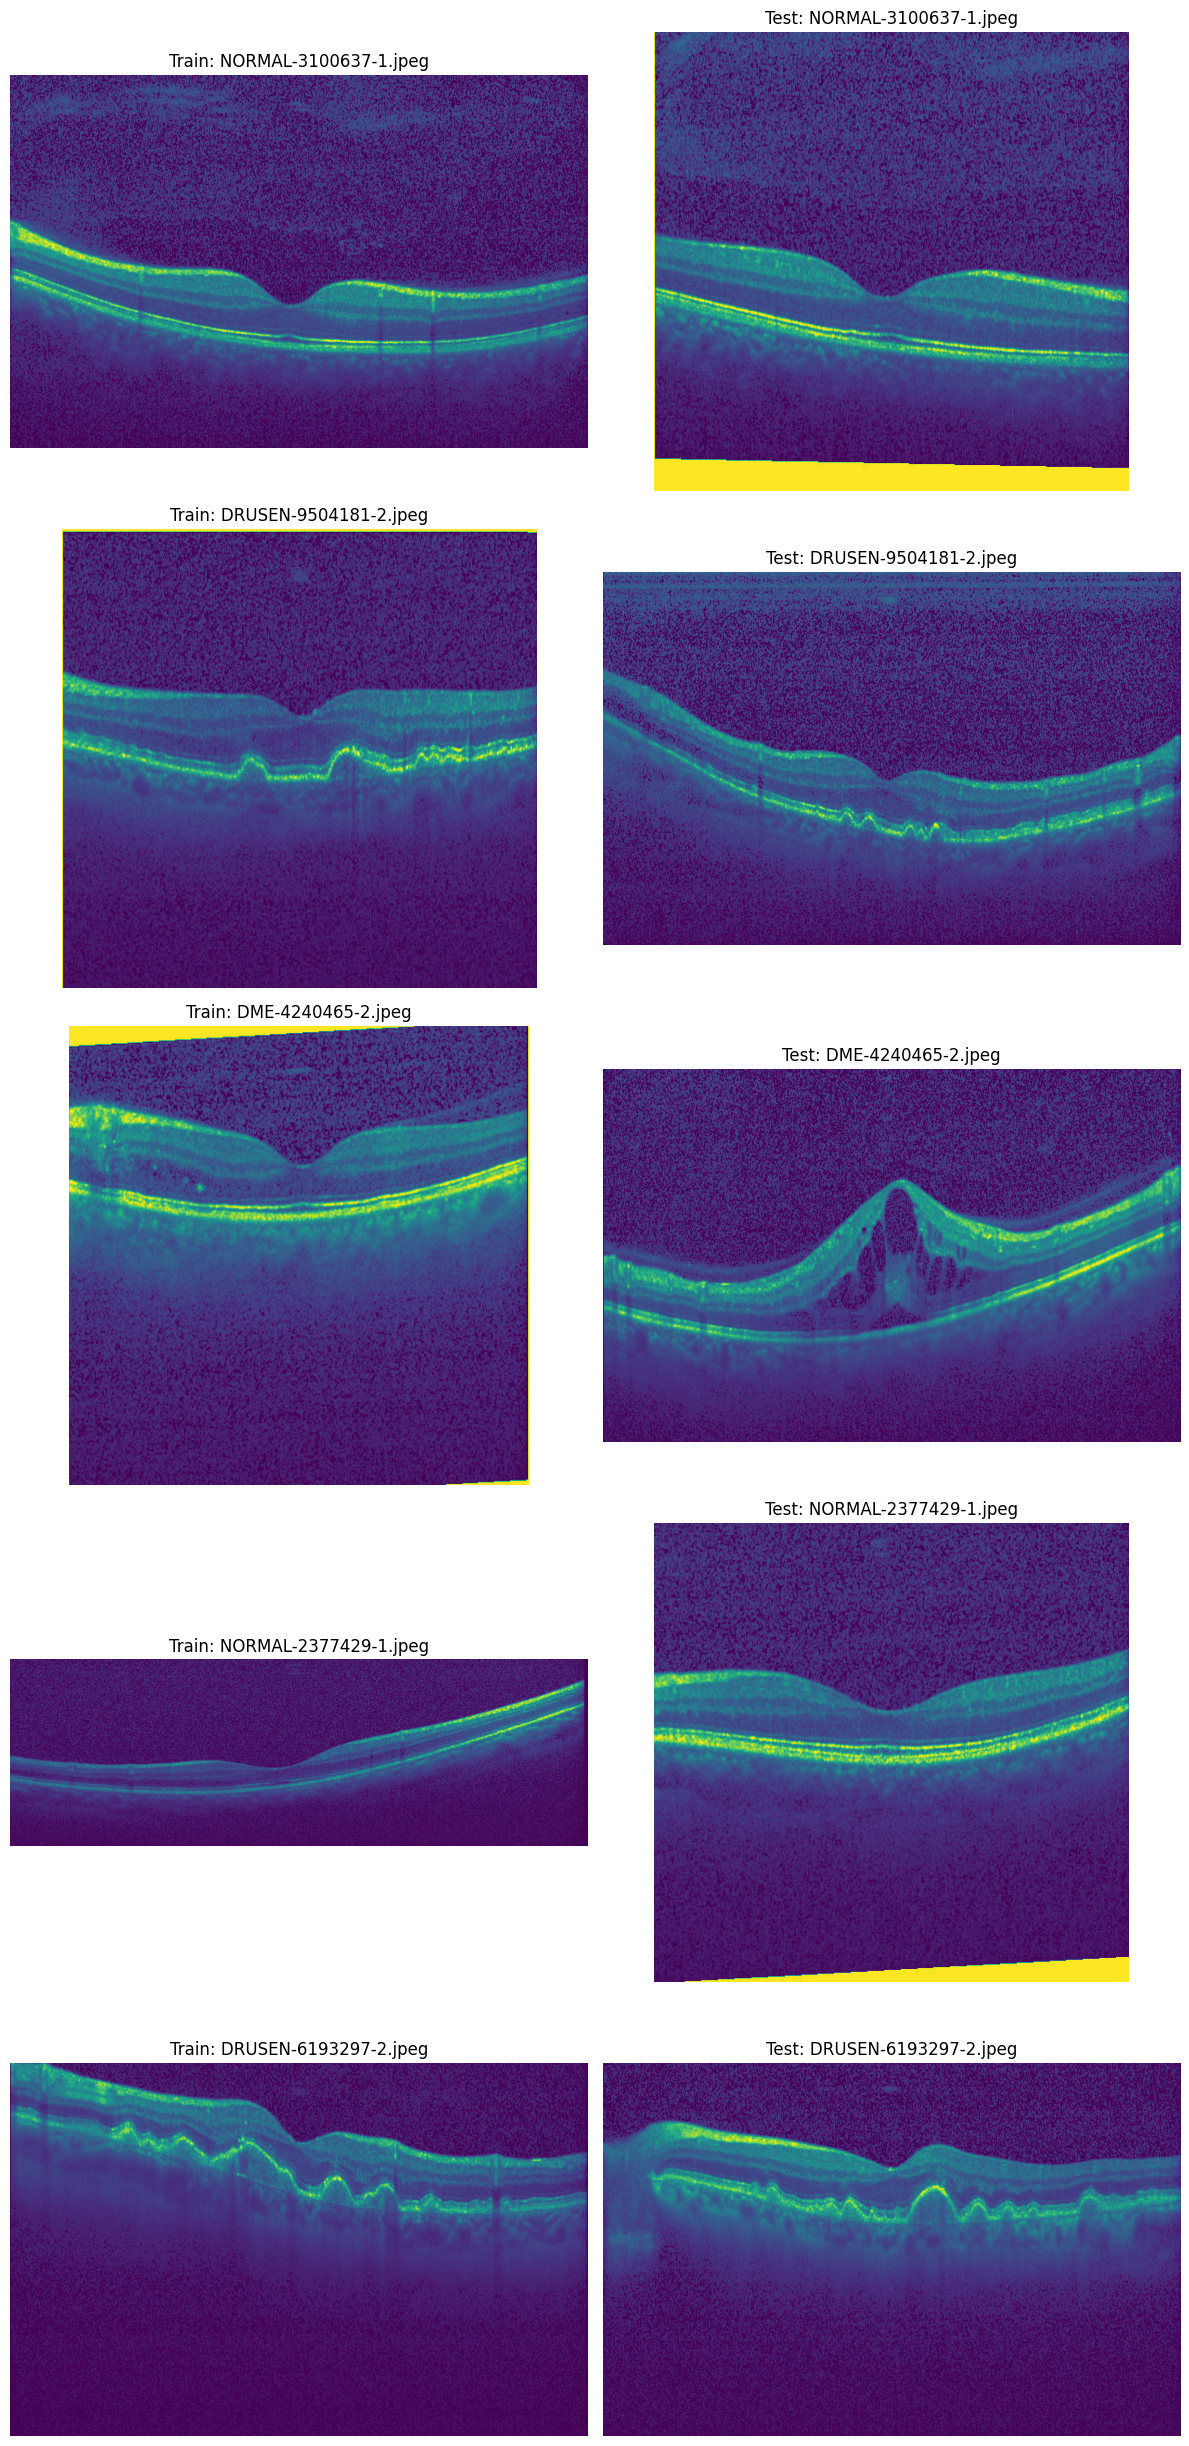

In [13]:
def get_all_files_by_name(folder, target_names):
    found = {}
    for root, _, files in os.walk(folder):
        for file in files:
            if file in target_names:
                found[file] = os.path.join(root, file)
    return found

# Дубликаты между train и test
duplicates_train_test = train_files & test_files
print(f"Найдено дубликатов между train и test: {len(duplicates_train_test)}")

# Получаем полные пути
train_duplicates = get_all_files_by_name(train_dir, duplicates_train_test)
test_duplicates = get_all_files_by_name(test_dir, duplicates_train_test)

# Сколько примеров показать
num_examples = 5
examples = list(duplicates_train_test)[:num_examples]

# Отображение
plt.figure(figsize=(12, 5 * num_examples))
for idx, fname in enumerate(examples):
    train_path = train_duplicates.get(fname)
    test_path = test_duplicates.get(fname)

    if not train_path or not test_path:
        continue

    # Train image
    plt.subplot(num_examples, 2, 2 * idx + 1)
    plt.imshow(Image.open(train_path))
    plt.title(f"Train: {fname}")
    plt.axis('off')

    # Test image
    plt.subplot(num_examples, 2, 2 * idx + 2)
    plt.imshow(Image.open(test_path))
    plt.title(f"Test: {fname}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
def compare_images(img1_path, img2_path):
    img1 = np.array(Image.open(img1_path).convert("L")).astype(np.float32)
    img2 = np.array(Image.open(img2_path).convert("L")).astype(np.float32)
    img1 = img1 / 255.0
    img2 = img2 / 255.0

    # Приводим к одному размеру 
    if img1.shape != img2.shape:
        return np.inf

    mae = np.mean(np.abs(img1 - img2))
    return mae

for fname in examples:
    train_path = train_duplicates.get(fname)
    test_path = test_duplicates.get(fname)
    if train_path and test_path:
        mae = compare_images(train_path, test_path)
        print(f"{fname} — MAE (средняя разница): {mae:.4f}")

NORMAL-3100637-1.jpeg — MAE (средняя разница): inf
DRUSEN-9504181-2.jpeg — MAE (средняя разница): inf
DME-4240465-2.jpeg — MAE (средняя разница): inf
NORMAL-2377429-1.jpeg — MAE (средняя разница): inf
DRUSEN-6193297-2.jpeg — MAE (средняя разница): 0.0899


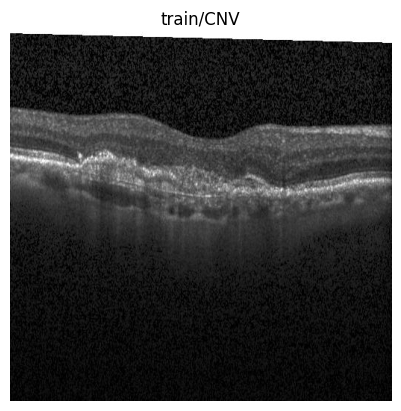

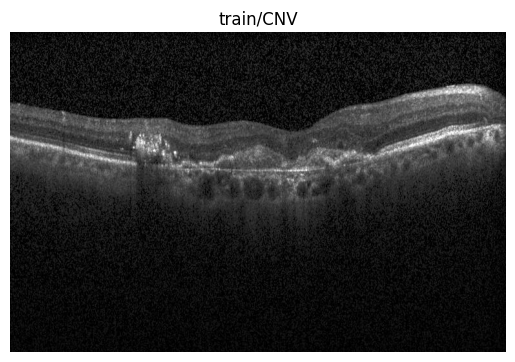

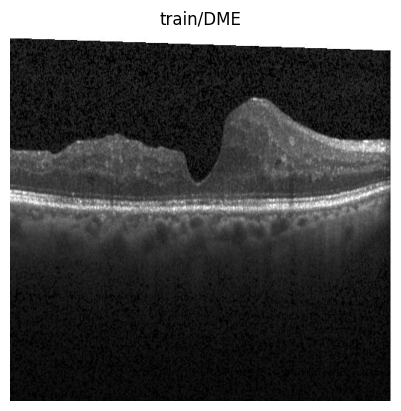

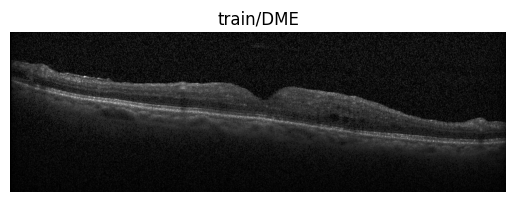

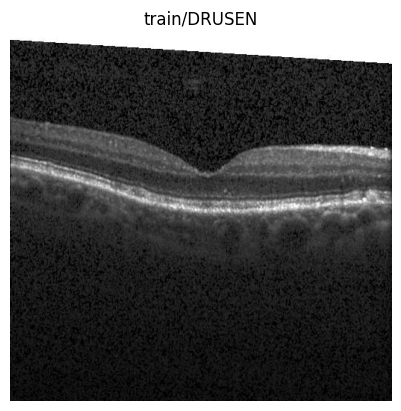

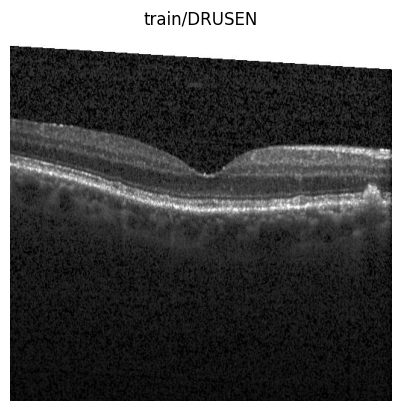

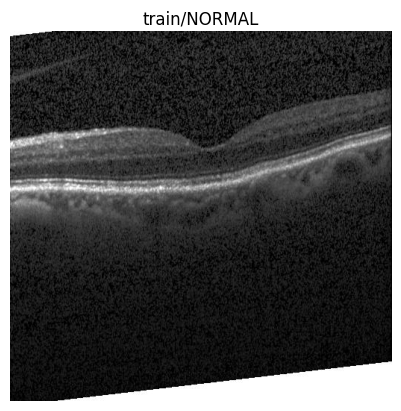

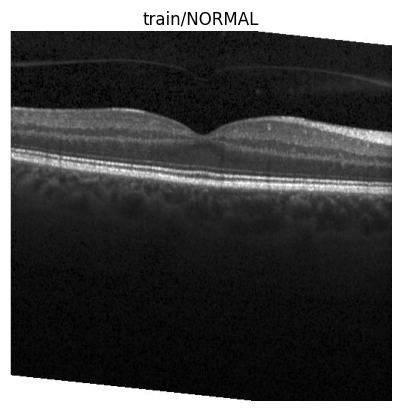

In [13]:
samples_per_class = 2
split = 'train'

for cls in os.listdir(os.path.join(data_root, split)):
    cls_path = os.path.join(data_root, split, cls)
    files = os.listdir(cls_path)[:samples_per_class]
    
    for f in files:
        img = Image.open(os.path.join(cls_path, f))
        plt.imshow(img, cmap='gray')
        plt.title(f"{split}/{cls}")
        plt.axis('off')
        plt.show()

In [ ]:
def extract_patient_id(filename):
    match = re.match(r"[A-Z]+-(\d+)-\d+\.jpe?g", filename)
    return match.group(1) if match else None

In [ ]:
def build_patient_map(root_dir):
    patient_map = defaultdict(list)
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg")):
                pid = extract_patient_id(f)
                if pid:
                    full_path = os.path.join(root, f)
                    patient_map[pid].append(full_path)
    return patient_map

In [ ]:
def split_patient_ids(patient_ids, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6
    train_ids, temp_ids = train_test_split(patient_ids, train_size=train_size, random_state=seed)
    val_ids, test_ids = train_test_split(temp_ids, train_size=val_size / (val_size + test_size), random_state=seed)
    return train_ids, val_ids, test_ids

In [ ]:
def copy_files(patient_map, train_ids, val_ids, test_ids, out_dir="clean_OCT"):
    for subset_name, subset_ids in zip(["train", "val", "test"], [train_ids, val_ids, test_ids]):
        for pid in subset_ids:
            for file_path in patient_map[pid]:
                class_name = os.path.basename(os.path.dirname(file_path))  # CNV, DME и т.д.
                dest_dir = os.path.join(out_dir, subset_name, class_name)
                os.makedirs(dest_dir, exist_ok=True)
                shutil.copy2(file_path, dest_dir)

In [ ]:
source_dir = r"C:\Users\555\Desktop\BioML\CV\practice\OCT2017"

In [ ]:
patient_map = build_patient_map(source_dir)

In [ ]:
all_patient_ids = list(patient_map.keys())
train_ids, val_ids, test_ids = split_patient_ids(all_patient_ids)

In [ ]:
copy_files(patient_map, train_ids, val_ids, test_ids, out_dir="C:\\Users\\555\\Desktop\\BioML\\CV\\clean_OCT")

In [23]:
data_root = r"C:\Users\555\Desktop\BioML\CV\clean_OCT"

In [25]:
split_counts = defaultdict(lambda: defaultdict(int))

for split in ['train', 'val', 'test']:
    split_path = os.path.join(data_root, split)
    if not os.path.exists(split_path):
        continue

    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if not os.path.isdir(cls_path):
            continue

        # Считаем только .jpg/.jpeg файлы
        count = len([
            f for f in os.listdir(cls_path)
            if f.lower().endswith((".jpg", ".jpeg"))
        ])
        split_counts[split][cls] = count

# Вывод
for split, class_counts in split_counts.items():
    print(f"\n{split.upper()}:")
    for cls, count in sorted(class_counts.items()):
        print(f"{cls:8s}: {count}")


TRAIN:
CNV     : 24463
DME     : 8487
DRUSEN  : 5788
NORMAL  : 18731

VAL:
CNV     : 6625
DME     : 1270
DRUSEN  : 1580
NORMAL  : 3865

TEST:
CNV     : 6128
DME     : 1665
DRUSEN  : 1252
NORMAL  : 3751


In [15]:
shapes = []

for split in ['train', 'val', 'test']:
    for cls in os.listdir(os.path.join(data_root, split)):
        path = os.path.join(data_root, split, cls)
        for fname in os.listdir(path)[:100]:
            img = Image.open(os.path.join(path, fname))
            shapes.append(img.size)

# Частые размеры
Counter(shapes).most_common(10)

[((512, 496), 506), ((768, 496), 179), ((512, 512), 102), ((1536, 496), 45)]

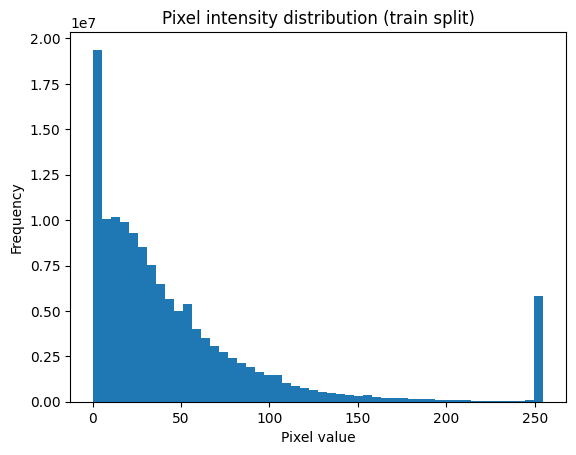

In [17]:
pixels = []

for split in ['train']:
    for cls in os.listdir(os.path.join(data_root, split)):
        path = os.path.join(data_root, split, cls)
        for fname in os.listdir(path)[:100]:
            img = Image.open(os.path.join(path, fname)).convert('L')  # grayscale
            pixels.extend(np.array(img).flatten())

plt.hist(pixels, bins=50)
plt.title("Pixel intensity distribution (train split)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

In [21]:
folder = os.path.join(data_root, 'train', 'NORMAL')
image_paths = sorted(os.listdir(folder))

def show_image(idx):
    img_path = os.path.join(folder, image_paths[idx])
    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"NORMAL — {idx}")
    plt.axis('off')
    plt.show()

interact(show_image, idx=widgets.IntSlider(value=0, min=0, max=len(image_paths)-1));

interactive(children=(IntSlider(value=0, description='idx', max=18730), Output()), _dom_classes=('widget-inter…

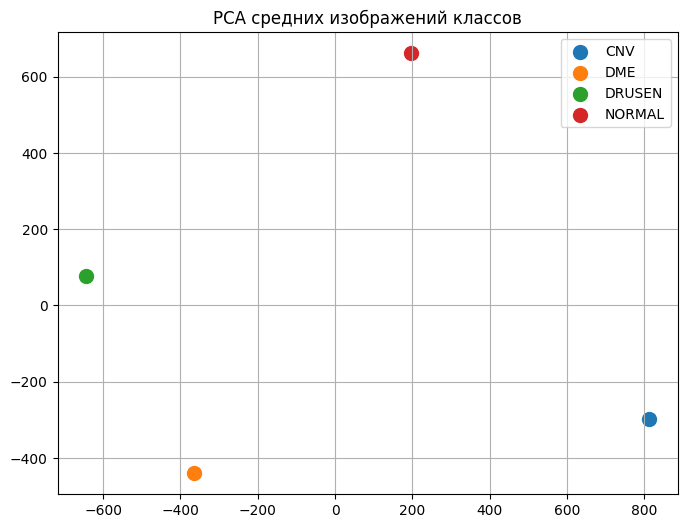

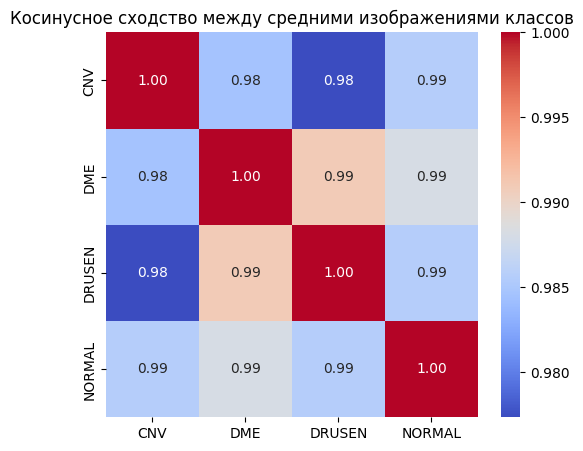

In [23]:
# Матрица сходства классов по среднему изображению (PCA / средний цвет)

img_size = 128
samples_per_class = 100
class_means = {}
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

for cls in classes:
    folder = os.path.join(data_root, 'train', cls)
    files = os.listdir(folder)[:samples_per_class]
    imgs = []

    for f in files:
        img = Image.open(os.path.join(folder, f)).convert("L").resize((img_size, img_size))
        imgs.append(np.array(img))

    mean_img = np.mean(np.stack(imgs), axis=0)  # (H, W)
    class_means[cls] = mean_img.flatten()  # (H*W)

# PCA для визуализации
X = np.stack(list(class_means.values()))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], label=cls, s=100)
plt.title("PCA средних изображений классов")
plt.legend()
plt.grid(True)
plt.show()

# Косинусное сходство
sim_matrix = cosine_similarity(X)
sim_df = pd.DataFrame(sim_matrix, index=classes, columns=classes)

plt.figure(figsize=(6, 5))
sns.heatmap(sim_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Косинусное сходство между средними изображениями классов")
plt.show()

## Первичный анализ датасета

- В датасете 4 класса: CNV, DME, DRUSEN, NORMAL.
- Структура уже организована в виде папок, что позволяет напрямую использовать `ImageFolder`.
- Размеры изображений: переменные, от 256×256 до 512×512.
- Градации серого (одноцветные снимки), характерные для ОКТ.
- Число изображений в каждом классе различается — нужно учесть это при обучении (class weights или sampler).

- Все значения очень близки к 1, что указывает на высокую визуальную схожесть средних изображений между классами.
- Особенно DME и NORMAL: 0.992
- DRUSEN и CNV тоже схожи, но чуть меньше — ~0.978–0.984.
- Общая картина: классы очень похожи визуально, и это создаёт сложность для классификатора.

## Кастомный Albumentations-трансформер для ImageFolder

In [27]:
class AlbumentationsTransform:
    def __init__(self, albumentations_transform):
        self.albumentations_transform = albumentations_transform

    def __call__(self, img):
        img = np.array(img.convert("RGB"))  # PIL -> numpy RGB
        augmented = self.albumentations_transform(image=img)
        return augmented["image"]

## Трансформации для train/val

In [29]:
train_transform = AlbumentationsTransform(A.Compose([
    A.Resize(224, 224),
    A.CLAHE(p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
]))

val_transform = AlbumentationsTransform(A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
]))

D:\Anaconda\envs\opencv_env\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [31]:
train_dataset = ImageFolder(os.path.join(data_root, "train"), transform=train_transform)
val_dataset   = ImageFolder(os.path.join(data_root, "val"), transform=val_transform)
test_dataset  = ImageFolder(os.path.join(data_root, "test"), transform=val_transform)

# class_to_idx сохраняет отображение классов
print(train_dataset.class_to_idx)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


## Визуализация аугментаций для мультикласса

In [13]:
def visualize_augmentations(albumentations_transform, dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4 * num_samples))

    for i in range(num_samples):
        path, label = dataset.samples[i]
        img = Image.open(path).convert("RGB")
        class_name = os.path.basename(os.path.dirname(path))  # Имя класса по папке

        # Оригинальное изображение после базового трансформера
        augmented = albumentations_transform(img)
        orig_img = augmented.permute(1, 2, 0).cpu().numpy()
        orig_img = (orig_img * 0.5) + 0.5  # разнормировка
        orig_img = np.clip(orig_img, 0, 1)

        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f"Original ({class_name})")
        axes[i, 0].axis('off')

        # Аугментации
        for j in range(1, 5):
            aug_img = albumentations_transform(img)
            aug_img = aug_img.permute(1, 2, 0).cpu().numpy()
            aug_img = (aug_img * 0.5) + 0.5
            aug_img = np.clip(aug_img, 0, 1)

            axes[i, j].imshow(aug_img)
            axes[i, j].set_title(f"Augmented {j}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

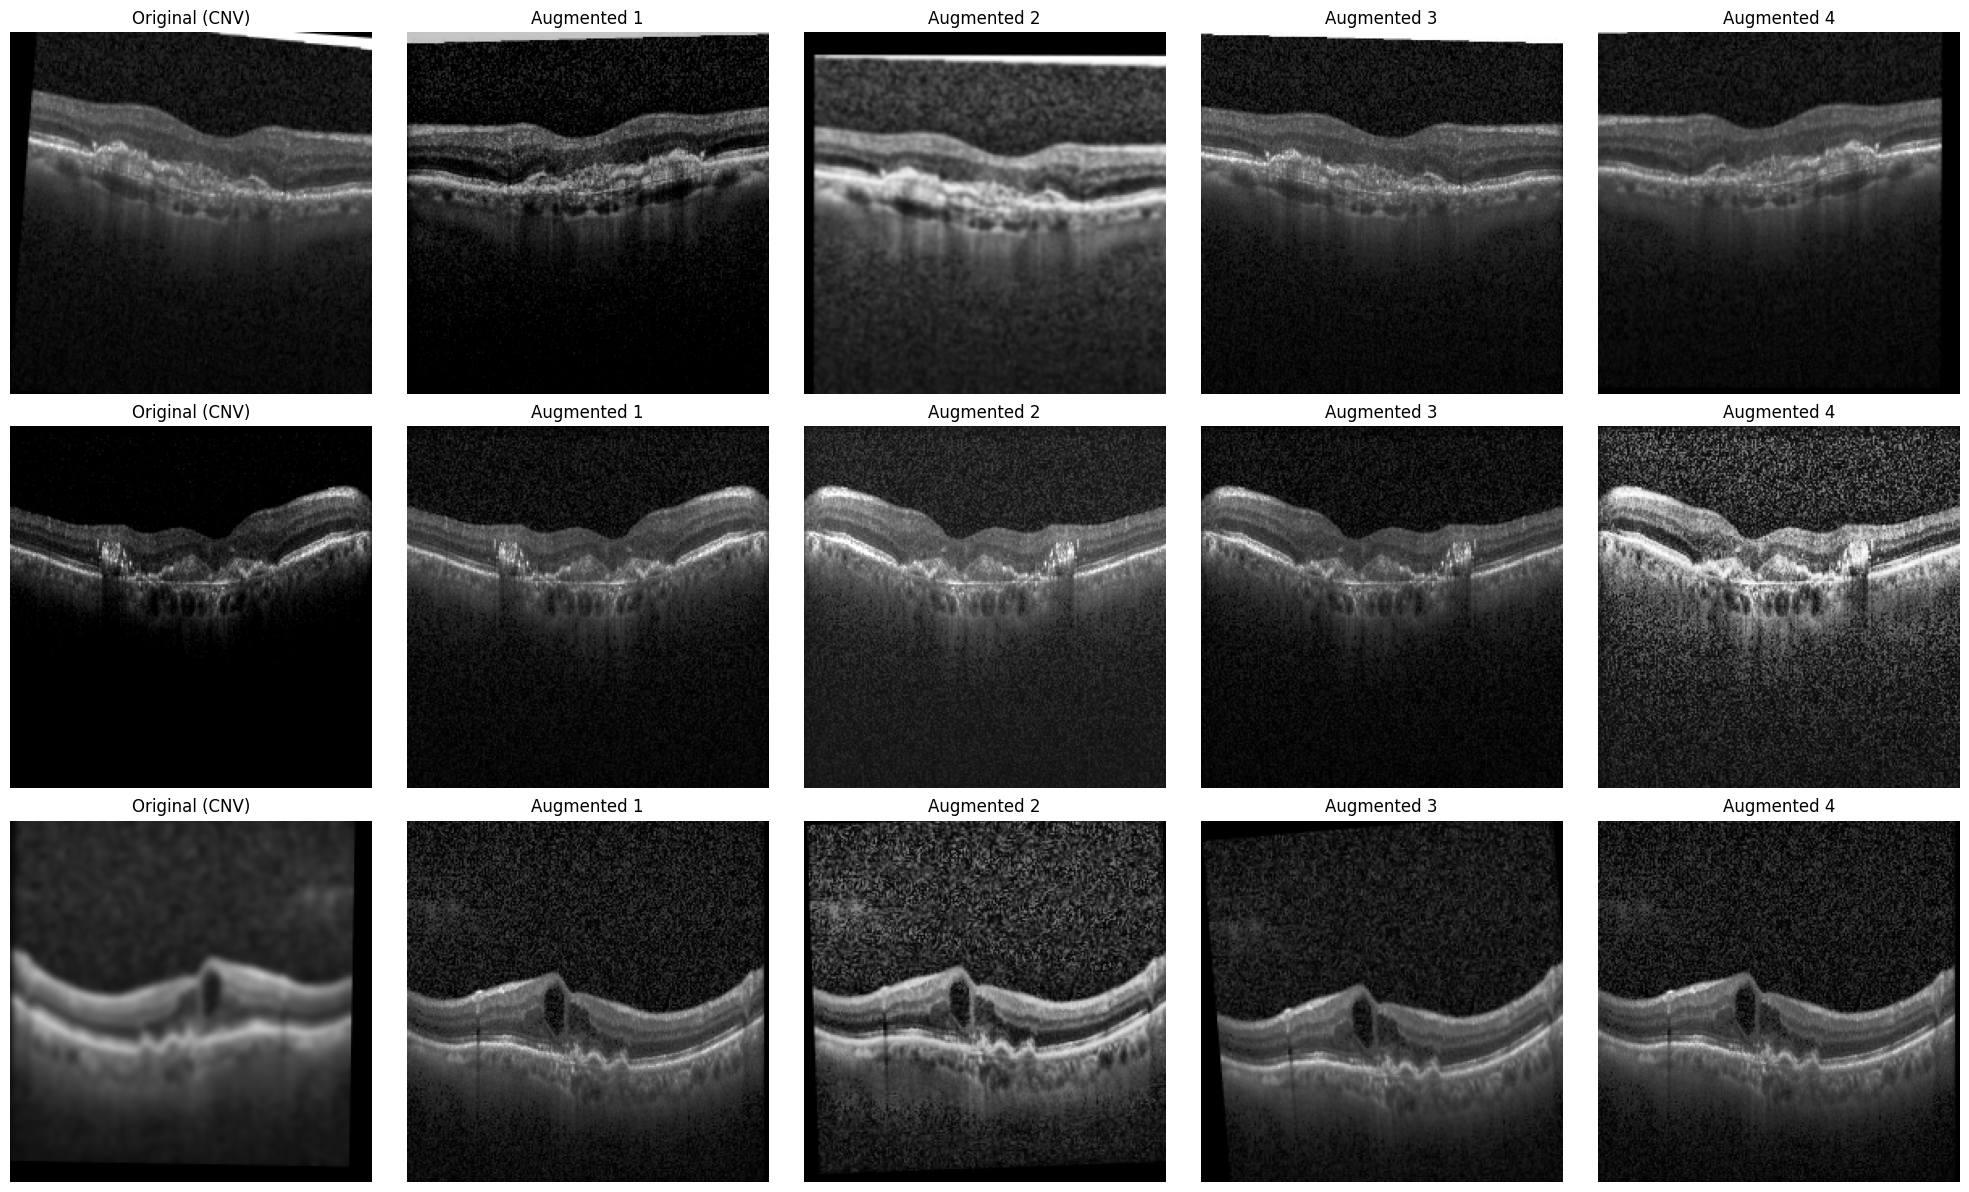

In [33]:
visualize_augmentations(train_transform, train_dataset, num_samples=3)

## EarlyStopping

In [33]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, path='best_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.path = path

    def step(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            return False  # don't stop
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # stop training
            return False

## Функция вычисления мультиклассовых метрик

In [35]:
def compute_multiclass_metrics(y_logits, y_true, class_names):
    y_pred = torch.argmax(y_logits, dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "precision_macro": precision_score(y_true, y_pred, average="macro"),
        "recall_macro": recall_score(y_true, y_pred, average="macro")
    }

    f1_per_class = f1_score(y_true, y_pred, average=None)
    for i, cls in enumerate(class_names):
        metrics[f"f1_{cls}"] = f1_per_class[i]

    return metrics, y_pred  

In [37]:
def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

## Визуализация истории обучения (plot_metrics)

In [39]:
def plot_metrics(history, save_path=None):
    epochs = len(history["train_loss"])
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history["train_loss"], label="Train Loss")
    plt.plot(range(epochs), history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), history["val_macro_f1"], label="f1_macro")
    plt.plot(range(epochs), history["val_weighted_f1"], label="f1_weighted")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation F1 Scores")
    plt.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

## Логирование в MLflow

In [41]:
def log_to_mlflow_multiclass(metrics, params, model=None, artifact_paths=None):
    mlflow.start_run()
    for k, v in metrics.items():
        mlflow.log_metric(k, v)
    for k, v in params.items():
        mlflow.log_param(k, v)
    if model is not None:
        mlflow.pytorch.log_model(model, "model")
    if artifact_paths:
        for path in artifact_paths:
            mlflow.log_artifact(path)
    mlflow.end_run()

## Leaderbord-таблица

In [43]:
def update_leaderboard(model_name: str, metrics: dict, training_time: float, csv_path):
    df_new = pd.DataFrame([{
        "model": model_name,
        "accuracy": metrics["accuracy"],
        "f1_macro": metrics["f1_macro"],
        "f1_weighted": metrics["f1_weighted"],
        "precision_macro": metrics["precision_macro"],
        "recall_macro": metrics["recall_macro"],
        "time_seconds": round(training_time, 2)
    }])
    try:
        df_existing = pd.read_csv(csv_path)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    except FileNotFoundError:
        df_combined = df_new
    df_combined.to_csv(csv_path, index=False)
    print(f"[LOG] Leaderboard обновлён: {model_name}")

In [45]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, early_stopping, model_name, class_names, log_dir):
    model.to(device)
    torch.backends.cudnn.benchmark = True

    history = {
        "train_loss": [], "val_loss": [],
        "val_macro_f1": [], "val_weighted_f1": []
    }

    best_metrics = None
    start_time = time.time()

    print(f"[INFO] Тренировка модели '{model_name}' на устройстве: {device}")
    print(f"[INFO] Начинается обучение на {epochs} эпох(и)...")
    print(f"[INFO] Размер train_loader: {len(train_loader)} | val_loader: {len(val_loader)}")
    print("=" * 60)

    for epoch in trange(epochs, desc="Эпохи", position=0):
        print(f"[EPOCH {epoch+1}/{epochs}] >>> Обучение")
        model.train()
        running_loss = 0.0

        train_bar = tqdm(train_loader, desc=f"[{epoch+1}] Train", leave=False, position=1)
        for batch_idx, (images, labels) in enumerate(train_bar):
            if batch_idx == 0:
                print(f"[EPOCH {epoch+1}] Первый batch получен, начинаем обучение на GPU...")
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)

        print(f"[EPOCH {epoch+1}] >>> Валидация")
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []

        val_bar = tqdm(val_loader, desc=f"[{epoch+1}] Val", leave=False, position=2)
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                all_preds.append(outputs)
                all_labels.append(labels)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        metrics, cm = compute_multiclass_metrics(all_preds, all_labels, class_names)

        print(f"[EPOCH {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss / len(val_loader):.4f}")
        print(f"[EPOCH {epoch+1}] F1 Macro: {metrics['f1_macro']:.4f} | F1 Weighted: {metrics['f1_weighted']:.4f}")
        print("-" * 60)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_macro_f1"].append(metrics["f1_macro"])
        history["val_weighted_f1"].append(metrics["f1_weighted"])

        run_dir = os.path.join(log_dir, model_name)
        os.makedirs(run_dir, exist_ok=True)

        plot_confusion_matrix(
            y_true=all_labels.cpu().numpy(),
            y_pred=torch.argmax(all_preds, dim=1).cpu().numpy(),
            class_names=class_names,
            save_path=os.path.join(run_dir, f"cm_epoch_{epoch+1}.png")
        )

        plot_metrics(history, save_path=os.path.join(run_dir, "metrics.png"))

        log_to_mlflow_multiclass(metrics, {"model": model_name, "epoch": epoch}, model=model,
                                 artifact_paths=[os.path.join(run_dir, f"cm_epoch_{epoch+1}.png")])

        if early_stopping.step(val_loss / len(val_loader), model):
            print("[INFO] Early stopping сработал.")
            break

        scheduler.step(val_loss / len(val_loader))

    total_time = time.time() - start_time
    print(f"[INFO] Обучение завершено за {total_time:.2f} сек.")

    update_leaderboard(model_name, metrics, total_time, csv_path=os.path.join(log_dir, "leaderboard.csv"))
    final_model_path = os.path.join(log_dir, f"final_{model_name}.pt")
    torch.save(model.state_dict(), final_model_path)
    print(f"[INFO] Модель сохранена: {final_model_path}")

    return history

In [47]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

    return epoch_loss / len(dataloader), torch.cat(all_preds), torch.cat(all_labels)

In [29]:
def evaluate_on_test(model, test_loader, device, class_names, model_name, csv_path):
    model.eval()
    model.to(device)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="[Test]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.append(outputs)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Подсчёт метрик
    metrics, cm = compute_multiclass_metrics(all_preds, all_labels, class_names)

    print("\n[TEST METRICS]")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    # Добавим в CSV
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    row = {
        "model_name": model_name,
        "macro_f1": metrics["macro_f1"],
        "weighted_f1": metrics["weighted_f1"],
        "accuracy": metrics["accuracy"],
        "roc_auc": metrics["roc_auc"],
        "pr_auc": metrics["pr_auc"],
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    df_row = pd.DataFrame([row])
    if os.path.exists(csv_path):
        df_row.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df_row.to_csv(csv_path, index=False)

    print(f"[INFO] Метрики теста добавлены в {csv_path}")

In [49]:
def get_random_directions(model):
    params_vector = torch.nn.utils.parameters_to_vector(model.parameters())
    direction1 = torch.randn_like(params_vector)
    direction2 = torch.randn_like(params_vector)
    direction1 /= torch.norm(direction1)
    direction2 /= torch.norm(direction2)
    return direction1, direction2

def perturb_model(model, base_state_dict, direction1, direction2, alpha, beta):
    model.load_state_dict(copy.deepcopy(base_state_dict))
    base_vector = torch.nn.utils.parameters_to_vector(model.parameters()).detach()
    new_vector = base_vector + alpha * direction1 + beta * direction2
    torch.nn.utils.vector_to_parameters(new_vector, model.parameters())

def plot_loss_surface_full_model(
    model,
    dataloader,
    criterion,
    device,
    grid_size=25,
    alpha_range=(-1.0, 1.0),
    beta_range=(-1.0, 1.0),
    title="Loss Surface (Full Model)",
    save_path=None
):
    model.eval()
    base_state_dict = copy.deepcopy(model.state_dict())
    dir1, dir2 = get_random_directions(model)

    # Один батч из даталоадера
    batch = next(iter(dataloader))
    X_tensor, y_tensor = batch
    X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)

    alphas = np.linspace(*alpha_range, grid_size)
    betas = np.linspace(*beta_range, grid_size)
    loss_surface = []

    print(f"[INFO] Вычисление loss surface по {grid_size}×{grid_size} точкам...")

    for alpha in alphas:
        row = []
        for beta in betas:
            perturb_model(model, base_state_dict, dir1, dir2, alpha, beta)
            with torch.inference_mode():
                outputs = model(X_tensor)
                loss = criterion(outputs, y_tensor).item()
            row.append(loss)
        loss_surface.append(row)

    # Построение поверхности
    A, B = np.meshgrid(alphas, betas)
    Z = np.array(loss_surface)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(A, B, Z, cmap='viridis', edgecolor='none')

    ax.set_title(title)
    ax.set_xlabel('Direction 1')
    ax.set_ylabel('Direction 2')
    ax.set_zlabel('Loss')
    fig.colorbar(surf, shrink=0.5, aspect=10)

    if save_path:
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"[LOG] Сохранено: {save_path}")
    else:
        plt.show()

## Базовая функция Grad-CAM

In [51]:
def generate_gradcam_on_test(model, test_loader, class_names, target_layers, device, output_dir, num_images=5):
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam.utils.image import show_cam_on_image
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    from tqdm import tqdm

    model.eval()
    model.to(device)
    cam = GradCAM(model=model, target_layers=target_layers)

    os.makedirs(output_dir, exist_ok=True)

    count = 0
    for images, labels in tqdm(test_loader, desc="Grad-CAM on Test"):
        images = images.to(device)
        labels = labels.to(device)

        for i in range(images.size(0)):
            if count >= num_images:
                return

            input_tensor = images[i].unsqueeze(0)
            img_np = images[i].detach().cpu().permute(1, 2, 0).numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

            target_class = labels[i].item()
            grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_class)])[0]

            if grayscale_cam is None or np.isnan(grayscale_cam).any():
                print(f"[WARN] CAM не получен для изображения #{count}")
                continue

            visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

            save_path = os.path.join(output_dir, f"gradcam_test_{count}_{class_names[target_class]}.png")
            plt.imsave(save_path, visualization)
            count += 1

In [53]:
test_path = r"C:\Users\555\Desktop\BioML\CV\practice\logs\test_metrics.csv"
log_dir = r'C:\Users\555\Desktop\BioML\CV\practice\logs'
mlflow.set_tracking_uri(f"file:{log_dir}/mlruns")
mlflow.set_experiment("OCT_Multiclass_Classification")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [65]:
# === 1. Инициализация модели ResNet18 (без заморозки) ===
def init_resnet50(num_classes=4):
    print("[INFO] Загружаем предобученную модель ResNet50...")
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    print("[INFO] Финальный слой переопределён.")
    return model

# === 2. Настройка веса классов для CrossEntropyLoss ===
print("[INFO] Считаем веса классов для CrossEntropyLoss...")
train_labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# === 3. Создание модели, loss, optimizer, scheduler ===
print("[INFO] Инициализируем модель и оптимизаторы...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "resnet50"
class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]
model = init_resnet50(num_classes=4).to(device)
print(f"[INFO] Модель загружена на устройство: {device}")

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# === 4. EarlyStopping и логирование ===
log_dir = "logs"
print("[INFO] Настройка EarlyStopping и логирования...")
early_stopping = EarlyStopping(patience=5, path=os.path.join(log_dir, f"best_{model_name}.pt"))

# === 5. Обучение ===
print("=" * 60)
print(f"[INFO] Начинаем обучение модели {model_name}...")
start_time = time.time()

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=10,
    early_stopping=early_stopping,
    model_name=model_name,
    class_names=class_names,
    log_dir=log_dir
)

training_time = time.time() - start_time
print(f"[INFO] Обучение завершено за {training_time:.2f} секунд.")
print("=" * 60)

[INFO] Считаем веса классов для CrossEntropyLoss...
[INFO] Инициализируем модель и оптимизаторы...
[INFO] Загружаем предобученную модель ResNet50...


D:\Anaconda\envs\opencv_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\opencv_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\555/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:20<00:00, 4.90MB/s]


[INFO] Финальный слой переопределён.
[INFO] Модель загружена на устройство: cuda
[INFO] Настройка EarlyStopping и логирования...
[INFO] Начинаем обучение модели resnet50...
[INFO] Тренировка модели 'resnet50' на устройстве: cuda
[INFO] Начинается обучение на 10 эпох(и)...
[INFO] Размер train_loader: 898 | val_loader: 209


Эпохи:   0%|          | 0/10 [00:00<?, ?it/s]

[EPOCH 1/10] >>> Обучение


[1] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 1] Первый batch получен, начинаем обучение на GPU...
[EPOCH 1] >>> Валидация


[1] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 1] Train Loss: 0.2494 | Val Loss: 0.2622
[EPOCH 1] F1 Macro: 0.8970 | F1 Weighted: 0.9227
------------------------------------------------------------


2025/06/03 20:49:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 20:50:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 20:50:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 2/10] >>> Обучение


[2] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 2] Первый batch получен, начинаем обучение на GPU...
[EPOCH 2] >>> Валидация


[2] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 2] Train Loss: 0.1660 | Val Loss: 0.2558
[EPOCH 2] F1 Macro: 0.8913 | F1 Weighted: 0.9134
------------------------------------------------------------


2025/06/03 21:00:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:00:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:00:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 3/10] >>> Обучение


[3] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 3] Первый batch получен, начинаем обучение на GPU...
[EPOCH 3] >>> Валидация


[3] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 3] Train Loss: 0.1394 | Val Loss: 0.2050
[EPOCH 3] F1 Macro: 0.9109 | F1 Weighted: 0.9324
------------------------------------------------------------


2025/06/03 21:10:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:11:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:11:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 4/10] >>> Обучение


[4] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 4] Первый batch получен, начинаем обучение на GPU...
[EPOCH 4] >>> Валидация


[4] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 4] Train Loss: 0.1280 | Val Loss: 0.2350
[EPOCH 4] F1 Macro: 0.8965 | F1 Weighted: 0.9230
------------------------------------------------------------


2025/06/03 21:20:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:21:04 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:21:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 5/10] >>> Обучение


[5] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 5] Первый batch получен, начинаем обучение на GPU...
[EPOCH 5] >>> Валидация


[5] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 5] Train Loss: 0.1145 | Val Loss: 0.1777
[EPOCH 5] F1 Macro: 0.9255 | F1 Weighted: 0.9455
------------------------------------------------------------


2025/06/03 21:31:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:31:32 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:31:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 6/10] >>> Обучение


[6] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 6] Первый batch получен, начинаем обучение на GPU...
[EPOCH 6] >>> Валидация


[6] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 6] Train Loss: 0.1046 | Val Loss: 0.1760
[EPOCH 6] F1 Macro: 0.9252 | F1 Weighted: 0.9444
------------------------------------------------------------


2025/06/03 21:41:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:41:51 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:41:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 7/10] >>> Обучение


[7] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 7] Первый batch получен, начинаем обучение на GPU...
[EPOCH 7] >>> Валидация


[7] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 7] Train Loss: 0.0965 | Val Loss: 0.2660
[EPOCH 7] F1 Macro: 0.8962 | F1 Weighted: 0.9201
------------------------------------------------------------


2025/06/03 21:51:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:52:02 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 21:52:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 8/10] >>> Обучение


[8] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 8] Первый batch получен, начинаем обучение на GPU...
[EPOCH 8] >>> Валидация


[8] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 8] Train Loss: 0.0947 | Val Loss: 0.2124
[EPOCH 8] F1 Macro: 0.9215 | F1 Weighted: 0.9416
------------------------------------------------------------


2025/06/03 22:02:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 22:02:19 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 22:02:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 9/10] >>> Обучение


[9] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 9] Первый batch получен, начинаем обучение на GPU...
[EPOCH 9] >>> Валидация


[9] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 9] Train Loss: 0.0849 | Val Loss: 0.2098
[EPOCH 9] F1 Macro: 0.9155 | F1 Weighted: 0.9390
------------------------------------------------------------


2025/06/03 22:12:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 22:12:31 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 22:12:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 10/10] >>> Обучение


[10] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 10] Первый batch получен, начинаем обучение на GPU...
[EPOCH 10] >>> Валидация


[10] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 10] Train Loss: 0.0668 | Val Loss: 0.1878
[EPOCH 10] F1 Macro: 0.9272 | F1 Weighted: 0.9466
------------------------------------------------------------


2025/06/03 22:22:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 22:22:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 22:22:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[INFO] Обучение завершено за 6228.10 сек.
[LOG] Leaderboard обновлён: resnet50
[INFO] Модель сохранена: logs\final_resnet50.pt
[INFO] Обучение завершено за 6228.32 секунд.


In [69]:
# === Финальная проверка на тесте ===
model.load_state_dict(torch.load(r'C:\Users\555\Desktop\BioML\CV\practice\logs\final_resnet50.pt'))  # загружаем сохранённую модель
model.eval()

start_time = time.time()
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
test_metrics, test_cm = compute_multiclass_metrics(test_preds, test_labels, class_names)
total_time = time.time() - start_time

print("\nМетрики на тестовой выборке:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

# === Обновляем leaderboard по тестовым метрикам ===
update_leaderboard(
    model_name,
    test_metrics,
    training_time = total_time,
    csv_path=os.path.join(log_dir, "test_metrics.csv")  
)

# === Дополнительно: сохраняем confusion matrix для теста ===
plot_confusion_matrix(
    y_true=test_labels.cpu().numpy(),
    y_pred=torch.argmax(test_preds, dim=1).cpu().numpy(),
    class_names=["CNV", "DME", "DRUSEN", "NORMAL"],
    save_path=os.path.join(log_dir, model_name, "confusion_matrix_test.png")
)

C:\Users\555\AppData\Local\Temp\ipykernel_5932\448501068.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\555\Desktop\BioML\CV

Validation:   0%|          | 0/200 [00:00<?, ?it/s]


Метрики на тестовой выборке:
accuracy: 0.9513
f1_macro: 0.9305
f1_weighted: 0.9517
precision_macro: 0.9224
recall_macro: 0.9391
f1_CNV: 0.9685
f1_DME: 0.9135
f1_DRUSEN: 0.8718
f1_NORMAL: 0.9680
[LOG] Leaderboard обновлён: resnet50


In [71]:
generate_gradcam_on_test(
    model=model,
    test_loader=test_loader,
    class_names=["CNV", "DME", "DRUSEN", "NORMAL"],
    target_layers=[model.layer4[-1]],  # для ResNet18/50
    device=device,
    output_dir="logs/resnet50/gradcam_test",
    num_images=10
)

Grad-CAM on Test:   0%|          | 0/200 [00:03<?, ?it/s]


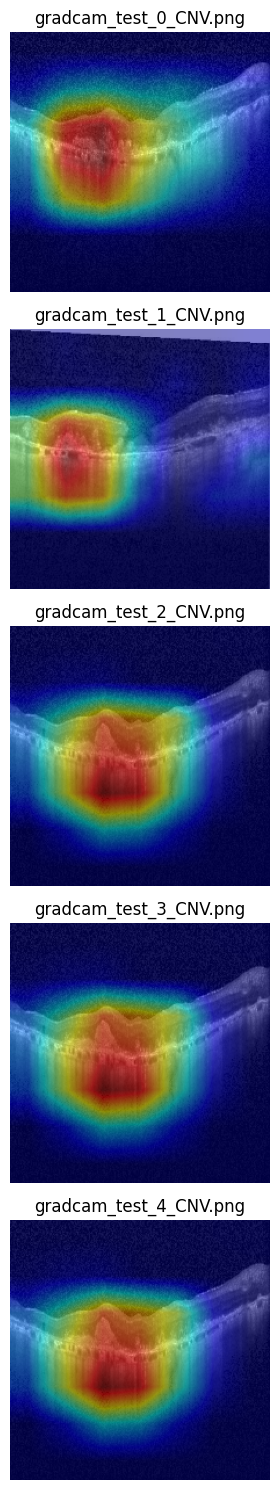

In [73]:
def show_gradcam_examples(output_dir, num_examples=5):
    """
    Выводит num_examples Grad-CAM изображений из указанной папки.
    """
    images = sorted([
        f for f in os.listdir(output_dir)
        if f.endswith(".png")
    ])

    if not images:
        print("Нет Grad-CAM изображений в папке.")
        return

    num_examples = min(num_examples, len(images))
    plt.figure(figsize=(15, 3 * num_examples))

    for i in range(num_examples):
        img_path = os.path.join(output_dir, images[i])
        img = Image.open(img_path)

        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(images[i])

    plt.tight_layout()
    plt.show()

# Пример вызова:
show_gradcam_examples("logs/resnet50/gradcam_test", num_examples=5)

In [75]:
def get_subset_loader(full_loader, num_samples, batch_size, shuffle=False):
    dataset = full_loader.dataset
    indices = list(range(num_samples))
    subset = Subset(dataset, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

In [79]:
subset_loader = get_subset_loader(test_loader, num_samples=64, batch_size=64)

In [81]:
plot_loss_surface_full_model(
    model=model,
    dataloader=subset_loader,
    criterion=nn.CrossEntropyLoss(),
    device=device,
    grid_size=25,
    title="Loss Surface — ResNet18 (64 Test Images)",
    save_path="logs/loss_surface_resnet50_subset.png"
)

[INFO] Вычисление loss surface по 25×25 точкам...
[LOG] Сохранено: logs/loss_surface_resnet50_subset.png


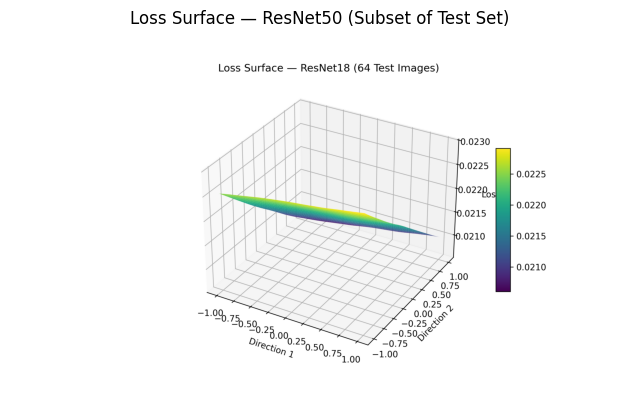

In [83]:
# Загрузка и отображение
img = Image.open("logs/loss_surface_resnet50_subset.png")

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Loss Surface — ResNet50 (Subset of Test Set)")
plt.show()

In [85]:
import gc
import torch

# Удаляем модель и переменные
del model
del optimizer
del scheduler
del criterion

# Очистка мусора
gc.collect()

# Очистка кэша CUDA
torch.cuda.empty_cache()
print(f"Используется память: {torch.cuda.memory_allocated() / 1024**3:.2f} ГБ")
print(f"Зарезервировано:     {torch.cuda.memory_reserved() / 1024**3:.2f} ГБ")

Используется память: 0.02 ГБ
Зарезервировано:     0.07 ГБ


## EfficientNetB0

### Инициализация EfficientNetB0 и параметров

In [87]:
# === EfficientNetB0: инициализация модели, оптимизаторов, логирования ===

def init_efficientnet_b0(num_classes=4):
    print("[INFO] Загружаем предобученную модель EfficientNetB0...")
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
    print("[INFO] Финальный слой уже под num_classes.")
    return model

# === Настройка весов классов ===
train_labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# === Инициализация ===
model_name = "EfficientNetB0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]

model = init_efficientnet_b0(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

early_stopping = EarlyStopping(patience=3, path=os.path.join(log_dir, f"best_{model_name}.pt"))

[INFO] Загружаем предобученную модель EfficientNetB0...
[INFO] Финальный слой уже под num_classes.


### Обучение EfficientNetB0

In [89]:
# === Обучение EfficientNetB0 ===
print("=" * 60)
print(f"[INFO] Начинаем обучение модели {model_name}...")
start_time = time.time()

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=10,
    early_stopping=early_stopping,
    model_name=model_name,
    class_names=class_names,
    log_dir=log_dir
)

training_time = time.time() - start_time
print(f"[INFO] Обучение завершено за {training_time:.2f} секунд.")
print("=" * 60)

[INFO] Начинаем обучение модели EfficientNetB0...
[INFO] Тренировка модели 'EfficientNetB0' на устройстве: cuda
[INFO] Начинается обучение на 10 эпох(и)...
[INFO] Размер train_loader: 898 | val_loader: 209


Эпохи:   0%|          | 0/10 [00:00<?, ?it/s]

[EPOCH 1/10] >>> Обучение


[1] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 1] Первый batch получен, начинаем обучение на GPU...
[EPOCH 1] >>> Валидация


[1] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 1] Train Loss: 0.5545 | Val Loss: 0.2704
[EPOCH 1] F1 Macro: 0.8848 | F1 Weighted: 0.9139
------------------------------------------------------------


2025/06/03 22:41:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 22:41:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 2/10] >>> Обучение


[2] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 2] Первый batch получен, начинаем обучение на GPU...
[EPOCH 2] >>> Валидация


[2] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 2] Train Loss: 0.2282 | Val Loss: 0.2050
[EPOCH 2] F1 Macro: 0.9103 | F1 Weighted: 0.9346
------------------------------------------------------------


2025/06/03 22:49:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 22:49:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 3/10] >>> Обучение


[3] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 3] Первый batch получен, начинаем обучение на GPU...
[EPOCH 3] >>> Валидация


[3] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 3] Train Loss: 0.1733 | Val Loss: 0.2070
[EPOCH 3] F1 Macro: 0.9118 | F1 Weighted: 0.9351
------------------------------------------------------------


2025/06/03 22:57:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 22:57:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 4/10] >>> Обучение


[4] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 4] Первый batch получен, начинаем обучение на GPU...
[EPOCH 4] >>> Валидация


[4] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 4] Train Loss: 0.1421 | Val Loss: 0.1853
[EPOCH 4] F1 Macro: 0.9175 | F1 Weighted: 0.9398
------------------------------------------------------------


2025/06/03 23:04:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 23:05:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 5/10] >>> Обучение


[5] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 5] Первый batch получен, начинаем обучение на GPU...
[EPOCH 5] >>> Валидация


[5] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 5] Train Loss: 0.1244 | Val Loss: 0.2303
[EPOCH 5] F1 Macro: 0.9113 | F1 Weighted: 0.9327
------------------------------------------------------------


2025/06/03 23:12:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 23:12:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 6/10] >>> Обучение


[6] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 6] Первый batch получен, начинаем обучение на GPU...
[EPOCH 6] >>> Валидация


[6] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 6] Train Loss: 0.1121 | Val Loss: 0.2092
[EPOCH 6] F1 Macro: 0.9177 | F1 Weighted: 0.9394
------------------------------------------------------------


2025/06/03 23:20:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 23:20:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 7/10] >>> Обучение


[7] Train:   0%|          | 0/898 [00:00<?, ?it/s]

[EPOCH 7] Первый batch получен, начинаем обучение на GPU...
[EPOCH 7] >>> Валидация


[7] Val:   0%|          | 0/209 [00:00<?, ?it/s]

[EPOCH 7] Train Loss: 0.0986 | Val Loss: 0.2029
[EPOCH 7] F1 Macro: 0.9230 | F1 Weighted: 0.9431
------------------------------------------------------------


2025/06/03 23:27:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/03 23:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[INFO] Early stopping сработал.
[INFO] Обучение завершено за 3281.46 сек.
[LOG] Leaderboard обновлён: EfficientNetB0
[INFO] Модель сохранена: logs\final_EfficientNetB0.pt
[INFO] Обучение завершено за 3281.58 секунд.


### Grad-CAM для EfficientNetB0

In [97]:
# === Grad-CAM EfficientNetB0 ===
generate_gradcam_on_test(
    model=model,
    test_loader=test_loader,
    class_names=class_names,
    target_layers=[model.conv_head],  
    device=device,
    output_dir="logs/EfficientNetB0/gradcam_test",
    num_images=10
)

Grad-CAM on Test:   0%|          | 0/200 [00:01<?, ?it/s]


### Тестовая оценка EfficientNetB0

In [91]:
# === Проверка на тестовой выборке EfficientNetB0 ===

model.load_state_dict(torch.load(os.path.join(log_dir, f"final_{model_name}.pt")))
model.eval()

start_time = time.time()
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
test_metrics, test_cm = compute_multiclass_metrics(test_preds, test_labels, class_names)
total_time = time.time() - start_time

print("\nМетрики на тестовой выборке:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

update_leaderboard(
    model_name,
    test_metrics,
    training_time=total_time,
    csv_path=os.path.join(log_dir, "test_metrics.csv")
)

plot_confusion_matrix(
    y_true=test_labels.cpu().numpy(),
    y_pred=torch.argmax(test_preds, dim=1).cpu().numpy(),
    class_names=class_names,
    save_path=os.path.join(log_dir, model_name, "confusion_matrix_test.png")
)

C:\Users\555\AppData\Local\Temp\ipykernel_5932\309189825.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(log_dir, f"final_{

Validation:   0%|          | 0/200 [00:00<?, ?it/s]


Метрики на тестовой выборке:
accuracy: 0.9412
f1_macro: 0.9157
f1_weighted: 0.9423
precision_macro: 0.9067
recall_macro: 0.9279
f1_CNV: 0.9639
f1_DME: 0.9097
f1_DRUSEN: 0.8307
f1_NORMAL: 0.9586
[LOG] Leaderboard обновлён: EfficientNetB0


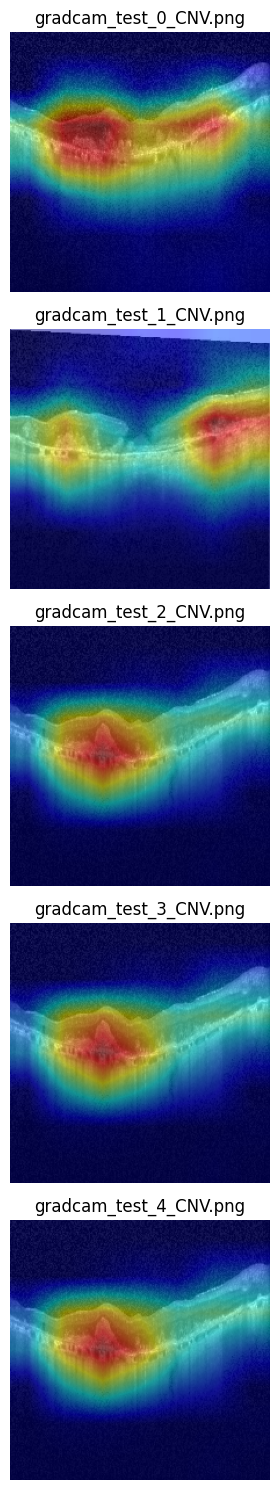

In [99]:
show_gradcam_examples("logs/EfficientNetB0/gradcam_test", num_examples=5)

## ConvNeXt-Tiny

In [13]:
def init_convnext_tiny(num_classes=4):
    print("[INFO] Загружаем предобученную модель ConvNeXt-Tiny...")
    model = create_model("convnext_tiny", pretrained=True, num_classes=num_classes)
    print("[INFO] Финальный слой адаптирован.")
    return model

In [55]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    num_workers=0, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    num_workers=0, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    num_workers=0, pin_memory=True
)

In [45]:
# === ConvNeXt-Tiny: инициализация, веса классов, обучение ===

print("[INFO] Считаем веса классов для CrossEntropyLoss...")
train_labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "convnext_tiny"
class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]
model = init_convnext_tiny(num_classes=4).to(device)
print(f"[INFO] Модель загружена на устройство: {device}")

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

log_dir = "logs"
print("[INFO] Настройка EarlyStopping и логирования...")
early_stopping = EarlyStopping(patience=5, path=os.path.join(log_dir, f"best_{model_name}.pt"))

# === Обучение ===
print("=" * 60)
print(f"[INFO] Начинаем обучение модели {model_name}...")
start_time = time.time()

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=10,
    early_stopping=early_stopping,
    model_name=model_name,
    class_names=class_names,
    log_dir=log_dir
)

training_time = time.time() - start_time
print(f"[INFO] Обучение завершено за {training_time:.2f} секунд.")
print("=" * 60)

[INFO] Считаем веса классов для CrossEntropyLoss...
[INFO] Загружаем предобученную модель ConvNeXt-Tiny...
[INFO] Финальный слой адаптирован.
[INFO] Модель загружена на устройство: cuda
[INFO] Настройка EarlyStopping и логирования...
[INFO] Начинаем обучение модели convnext_tiny...
[INFO] Тренировка модели 'convnext_tiny' на устройстве: cuda
[INFO] Начинается обучение на 10 эпох(и)...
[INFO] Размер train_loader: 1796 | val_loader: 417


Эпохи:   0%|          | 0/10 [00:00<?, ?it/s]

[EPOCH 1/10] >>> Обучение


[1] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 1] Первый batch получен, начинаем обучение на GPU...
[EPOCH 1] >>> Валидация


[1] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 1] Train Loss: 0.3201 | Val Loss: 0.2168
[EPOCH 1] F1 Macro: 0.9062 | F1 Weighted: 0.9297
------------------------------------------------------------


2025/06/04 21:41:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 21:41:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 2/10] >>> Обучение


[2] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 2] Первый batch получен, начинаем обучение на GPU...
[EPOCH 2] >>> Валидация


[2] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 2] Train Loss: 0.1691 | Val Loss: 0.1567
[EPOCH 2] F1 Macro: 0.9288 | F1 Weighted: 0.9482
------------------------------------------------------------


2025/06/04 21:55:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 21:55:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 3/10] >>> Обучение


[3] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 3] Первый batch получен, начинаем обучение на GPU...
[EPOCH 3] >>> Валидация


[3] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 3] Train Loss: 0.1502 | Val Loss: 0.2838
[EPOCH 3] F1 Macro: 0.8901 | F1 Weighted: 0.9121
------------------------------------------------------------


2025/06/04 22:09:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 22:09:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 4/10] >>> Обучение


[4] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 4] Первый batch получен, начинаем обучение на GPU...
[EPOCH 4] >>> Валидация


[4] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 4] Train Loss: 0.1290 | Val Loss: 0.1630
[EPOCH 4] F1 Macro: 0.9284 | F1 Weighted: 0.9484
------------------------------------------------------------


2025/06/04 22:23:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 22:23:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 5/10] >>> Обучение


[5] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 5] Первый batch получен, начинаем обучение на GPU...
[EPOCH 5] >>> Валидация


[5] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 5] Train Loss: 0.1200 | Val Loss: 0.1467
[EPOCH 5] F1 Macro: 0.9311 | F1 Weighted: 0.9505
------------------------------------------------------------


2025/06/04 22:37:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 22:37:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 6/10] >>> Обучение


[6] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 6] Первый batch получен, начинаем обучение на GPU...
[EPOCH 6] >>> Валидация


[6] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 6] Train Loss: 0.1066 | Val Loss: 0.1728
[EPOCH 6] F1 Macro: 0.9241 | F1 Weighted: 0.9447
------------------------------------------------------------


2025/06/04 22:51:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 22:51:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 7/10] >>> Обучение


[7] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 7] Первый batch получен, начинаем обучение на GPU...
[EPOCH 7] >>> Валидация


[7] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 7] Train Loss: 0.1004 | Val Loss: 0.1606
[EPOCH 7] F1 Macro: 0.9245 | F1 Weighted: 0.9459
------------------------------------------------------------


2025/06/04 23:05:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 23:05:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 8/10] >>> Обучение


[8] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 8] Первый batch получен, начинаем обучение на GPU...
[EPOCH 8] >>> Валидация


[8] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 8] Train Loss: 0.0945 | Val Loss: 0.2033
[EPOCH 8] F1 Macro: 0.9210 | F1 Weighted: 0.9427
------------------------------------------------------------


2025/06/04 23:20:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 23:20:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 9/10] >>> Обучение


[9] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 9] Первый batch получен, начинаем обучение на GPU...
[EPOCH 9] >>> Валидация


[9] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 9] Train Loss: 0.0669 | Val Loss: 0.2203
[EPOCH 9] F1 Macro: 0.9124 | F1 Weighted: 0.9358
------------------------------------------------------------


2025/06/04 23:34:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 23:34:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 10/10] >>> Обучение


[10] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 10] Первый batch получен, начинаем обучение на GPU...
[EPOCH 10] >>> Валидация


[10] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 10] Train Loss: 0.0603 | Val Loss: 0.2197
[EPOCH 10] F1 Macro: 0.9230 | F1 Weighted: 0.9430
------------------------------------------------------------


2025/06/04 23:48:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/04 23:48:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[INFO] Early stopping сработал.
[INFO] Обучение завершено за 8510.28 сек.
[LOG] Leaderboard обновлён: convnext_tiny
[INFO] Модель сохранена: logs\final_convnext_tiny.pt
[INFO] Обучение завершено за 8510.55 секунд.


In [77]:
def evaluate_on_test(model, test_loader, device, class_names, model_name, csv_path):
    model.eval()
    model.to(device)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="[Test]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.append(outputs)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Подсчёт метрик
    metrics, cm = compute_multiclass_metrics(all_preds, all_labels, class_names)
    metrics["macro_f1"] = metrics["f1_macro"]
    metrics["weighted_f1"] = metrics["f1_weighted"]

    print("\n[TEST METRICS]")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    # Добавим в CSV
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    row = {
    "model": model_name,
    "accuracy": metrics["accuracy"],
    "f1_macro": metrics["f1_macro"],
    "f1_weighted": metrics["f1_weighted"],
    "precision_macro": metrics.get("precision_macro", None),
    "recall_macro": metrics.get("recall_macro", None),
    "time_seconds": None  # или вручную потом допишешь
}


    df_row = pd.DataFrame([row])
    if os.path.exists(csv_path):
        df_row.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df_row.to_csv(csv_path, index=False)

    print(f"[INFO] Метрики теста добавлены в {csv_path}")

In [71]:
from datetime import datetime

In [79]:
evaluate_on_test(
    model=model,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name=model_name,
    csv_path="logs/test_metrics.csv"
)

[Test]:   0%|          | 0/400 [00:00<?, ?it/s]


[TEST METRICS]
accuracy: 0.9476
f1_macro: 0.9257
f1_weighted: 0.9488
precision_macro: 0.9123
recall_macro: 0.9425
f1_CNV: 0.9650
f1_DME: 0.9253
f1_DRUSEN: 0.8448
f1_NORMAL: 0.9676
macro_f1: 0.9257
weighted_f1: 0.9488
[INFO] Метрики теста добавлены в logs/test_metrics.csv


In [49]:
# GradCAM
generate_gradcam_on_test(
    model=model,
    test_loader=test_loader,
    class_names=class_names,
    target_layers=[model.stages[-1]],
    device=device,
    output_dir="logs/gradcam_convnext",
    num_images=5
)

Grad-CAM on Test:   0%|          | 0/400 [00:02<?, ?it/s]


In [51]:
torch.save(model.state_dict(), f"logs/final_{model_name}.pt")
print(f"[INFO] Веса модели сохранены: logs/final_{model_name}.pt")

[INFO] Веса модели сохранены: logs/final_convnext_tiny.pt


In [63]:
class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]
model_name = "convnext_tiny"

In [19]:
model = init_convnext_tiny(num_classes=4)
model.load_state_dict(torch.load("logs/final_convnext_tiny.pt"))
model.to(device)
model.eval()

[INFO] Загружаем предобученную модель ConvNeXt-Tiny...
[INFO] Финальный слой адаптирован.


C:\Users\555\AppData\Local\Temp\ipykernel_14676\1843248233.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("logs/final_convnext_tiny.pt"

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [17]:
test_path = r"C:\Users\555\Desktop\BioML\CV\practice\logs\test_metrics.csv"
log_dir = r'C:\Users\555\Desktop\BioML\CV\practice\logs'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
res = pd.read_csv(test_path)
res.head(10)

model  accuracy  f1_macro  f1_weighted  precision_macro  \
0        resnet50  0.951313  0.930455     0.951745         0.922433   
1  EfficientNetB0  0.941153  0.915729     0.942262         0.906681   
2   convnext_tiny  0.947640  0.925663     0.948839         0.912320   

   recall_macro  time_seconds  
0      0.939138         79.87  
1      0.927922         63.70  
2      0.942530           NaN

## vit_tiny_patch16_224

In [91]:
from timm import create_model
from torch import nn

def init_vit_tiny_feature_extractor():
    model = create_model("vit_tiny_patch16_224", pretrained=True)
    model.head = nn.Identity()  # отключаем классификатор
    return model

In [93]:
class ViTFFNNClassifier(nn.Module):
    def __init__(self, backbone, embed_dim=192, num_classes=4, dropout=0.2):
        super().__init__()
        self.backbone = backbone  # ViT без head
        self.ffnn = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():  # замораживаем ViT
            x = self.backbone(x)
        return self.ffnn(x)

In [95]:
backbone = init_vit_tiny_feature_extractor()
model = ViTFFNNClassifier(backbone, embed_dim=192, num_classes=4).to(device)
model_name = "vit_tiny_ffnn"

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

D:\Anaconda\envs\opencv_env\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\555\.cache\huggingface\hub\models--timm--vit_tiny_patch16_224.augreg_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [99]:
print("[INFO] Считаем веса классов для CrossEntropyLoss...")
train_labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "vit_tiny_ffnn"
class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]

print("[INFO] Инициализируем модель ViT + FFNN...")
backbone = init_vit_tiny_feature_extractor()
model = ViTFFNNClassifier(backbone, embed_dim=192, num_classes=4).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

log_dir = "logs"
print("[INFO] Настройка EarlyStopping и логирования...")
early_stopping = EarlyStopping(patience=5, path=os.path.join(log_dir, f"best_{model_name}.pt"))

print("=" * 60)
print(f"[INFO] Начинаем обучение модели {model_name}...")
start_time = time.time()

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=10,
    early_stopping=early_stopping,
    model_name=model_name,
    class_names=class_names,
    log_dir=log_dir
)

training_time = time.time() - start_time
print(f"[INFO] Обучение завершено за {training_time:.2f} секунд.")
print("=" * 60)

[INFO] Считаем веса классов для CrossEntropyLoss...
[INFO] Инициализируем модель ViT + FFNN...
[INFO] Настройка EarlyStopping и логирования...
[INFO] Начинаем обучение модели vit_tiny_ffnn...
[INFO] Тренировка модели 'vit_tiny_ffnn' на устройстве: cuda
[INFO] Начинается обучение на 10 эпох(и)...
[INFO] Размер train_loader: 1796 | val_loader: 417


Эпохи:   0%|          | 0/10 [00:00<?, ?it/s]

[EPOCH 1/10] >>> Обучение


[1] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 1] Первый batch получен, начинаем обучение на GPU...
[EPOCH 1] >>> Валидация


[1] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 1] Train Loss: 0.8175 | Val Loss: 0.5536
[EPOCH 1] F1 Macro: 0.7244 | F1 Weighted: 0.7940
------------------------------------------------------------


2025/06/05 23:35:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/05 23:35:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 2/10] >>> Обучение


[2] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 2] Первый batch получен, начинаем обучение на GPU...
[EPOCH 2] >>> Валидация


[2] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 2] Train Loss: 0.6780 | Val Loss: 0.5223
[EPOCH 2] F1 Macro: 0.7307 | F1 Weighted: 0.7999
------------------------------------------------------------


2025/06/05 23:42:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/05 23:42:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 3/10] >>> Обучение


[3] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 3] Первый batch получен, начинаем обучение на GPU...
[EPOCH 3] >>> Валидация


[3] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 3] Train Loss: 0.6374 | Val Loss: 0.5562
[EPOCH 3] F1 Macro: 0.7277 | F1 Weighted: 0.7902
------------------------------------------------------------


2025/06/05 23:50:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/05 23:50:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 4/10] >>> Обучение


[4] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 4] Первый batch получен, начинаем обучение на GPU...
[EPOCH 4] >>> Валидация


[4] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 4] Train Loss: 0.6174 | Val Loss: 0.5697
[EPOCH 4] F1 Macro: 0.7206 | F1 Weighted: 0.7844
------------------------------------------------------------


2025/06/05 23:57:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/05 23:57:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 5/10] >>> Обучение


[5] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 5] Первый batch получен, начинаем обучение на GPU...
[EPOCH 5] >>> Валидация


[5] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 5] Train Loss: 0.6005 | Val Loss: 0.4926
[EPOCH 5] F1 Macro: 0.7468 | F1 Weighted: 0.8131
------------------------------------------------------------


2025/06/06 00:05:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/06 00:05:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 6/10] >>> Обучение


[6] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 6] Первый batch получен, начинаем обучение на GPU...
[EPOCH 6] >>> Валидация


[6] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 6] Train Loss: 0.5838 | Val Loss: 0.4754
[EPOCH 6] F1 Macro: 0.7526 | F1 Weighted: 0.8175
------------------------------------------------------------


2025/06/06 00:12:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/06 00:13:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 7/10] >>> Обучение


[7] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 7] Первый batch получен, начинаем обучение на GPU...
[EPOCH 7] >>> Валидация


[7] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 7] Train Loss: 0.5728 | Val Loss: 0.4878
[EPOCH 7] F1 Macro: 0.7549 | F1 Weighted: 0.8154
------------------------------------------------------------


2025/06/06 00:20:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/06 00:20:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 8/10] >>> Обучение


[8] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 8] Первый batch получен, начинаем обучение на GPU...
[EPOCH 8] >>> Валидация


[8] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 8] Train Loss: 0.5617 | Val Loss: 0.4903
[EPOCH 8] F1 Macro: 0.7491 | F1 Weighted: 0.8132
------------------------------------------------------------


2025/06/06 00:28:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/06 00:28:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 9/10] >>> Обучение


[9] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 9] Первый batch получен, начинаем обучение на GPU...
[EPOCH 9] >>> Валидация


[9] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 9] Train Loss: 0.5575 | Val Loss: 0.5310
[EPOCH 9] F1 Macro: 0.7412 | F1 Weighted: 0.7994
------------------------------------------------------------


2025/06/06 00:35:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/06 00:35:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[EPOCH 10/10] >>> Обучение


[10] Train:   0%|          | 0/1796 [00:00<?, ?it/s]

[EPOCH 10] Первый batch получен, начинаем обучение на GPU...
[EPOCH 10] >>> Валидация


[10] Val:   0%|          | 0/417 [00:00<?, ?it/s]

[EPOCH 10] Train Loss: 0.5493 | Val Loss: 0.4737
[EPOCH 10] F1 Macro: 0.7560 | F1 Weighted: 0.8218
------------------------------------------------------------


2025/06/06 00:43:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/06 00:43:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[INFO] Обучение завершено за 4565.86 сек.
[LOG] Leaderboard обновлён: vit_tiny_ffnn
[INFO] Модель сохранена: logs\final_vit_tiny_ffnn.pt
[INFO] Обучение завершено за 4565.91 секунд.


In [101]:
evaluate_on_test(
    model=model,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name=model_name,
    csv_path="logs/test_metrics.csv"
)

[Test]:   0%|          | 0/400 [00:00<?, ?it/s]


[TEST METRICS]
accuracy: 0.8396
f1_macro: 0.7742
f1_weighted: 0.8451
precision_macro: 0.7597
recall_macro: 0.7955
f1_CNV: 0.9004
f1_DME: 0.7835
f1_DRUSEN: 0.5236
f1_NORMAL: 0.8895
macro_f1: 0.7742
weighted_f1: 0.8451
[INFO] Метрики теста добавлены в logs/test_metrics.csv


# Выводы по моделям:
1. ResNet50 — лидер по большинству метрик
Самая высокая точность, F1 и precision.
Отличный baseline для медицинской классификации.

2. ConvNeXt-Tiny — достойная альтернатива
Очень близко к ResNet50 по всем метрикам, даже немного выше по recall_macro.
Хорошо подходит, если важен recall 

3. EfficientNetB0
Чуть ниже по всем метрикам, но тоже показывает стабильные результаты.

4. ViT-Tiny + FFNN
Значительно уступает по всем метрикам.
Это ожидаемо: ViT без fine-tuning как эмбеддер не раскрывает потенциал.
Подходит скорее для сравнения или как часть бенчмарка.

# Рекомендации:
Финальная модель для деплоя: ResNet50 или ConvNeXt-Tiny.
Если важна интерпретируемость: ResNet легче использовать с Grad-CAM.
ViT стоит использовать только при fine-tuning или как мультимодальную основу.